# Code Hotspots

We are looking for hotspots on the project.

For that we are going to use the following datasets:

- git history
- Class structure

These will be connected to create a graph, where we can easily see the hotspots. For this example, a hotspot will be a class which is both very complex, and changes frequently.

The complexity will be calculated from the number of lines and cyclomatic complexity of its methods. While the number of changes comes directly from the git history.

# Setting Up

In [1]:
import pandas as pd
import calendar
import numpy as np
import matplotlib.pyplot as plt 

history = pd.read_json("../datasets/git_history_junit4.gz", encoding='utf-8-sig')
classes = pd.read_json("../datasets/class_structure_junit4.gz", encoding='utf-8-sig')

# To stop pandas from removing data
history = history.fillna("")
classes = classes.fillna("")

# Exploring Data

The history includes all the changes made in the repository. We will need little more than counting how many times each file appears.

In [2]:
history

,sha,date,time,author,author_email,author_id,commiter,message,modificationKind,file,fileType,class,package
0,3a5c6b4d08f408c8ca6a8e0bae71a9bc5a8f97e8,2020-08-02,20:24:18 +0200,Rahul Nagekar <rahul.nagekar1@gmail.com>,rahul.nagekar1@gmail.com,Rahul Nagekar <rahul.nagekar1@gmail.com>,GitHub <noreply@github.com>,Deprecated since jdk9 replacing constructor in...,M,src/main/java/junit/framework/Assert.java,java,Assert,/junit/framework
1,44cd8f80dbac11849a42a5d73fc9b5ddc75cd1b4,2016-12-01,21:35:45 +0100,Kevin Cooney <kcooney@google.com>,kcooney@users.noreply.github.com,Kevin Cooney <kcooney@users.noreply.github.com>,Stefan Birkner <github@stefan-birkner.de>,Change generics on ExpectedException.expectCau...,M,src/main/java/org/junit/internal/matchers/Thro...,java,ThrowableCauseMatcher,/org/junit/internal/matchers
2,44cd8f80dbac11849a42a5d73fc9b5ddc75cd1b4,2016-12-01,21:35:45 +0100,Kevin Cooney <kcooney@google.com>,kcooney@users.noreply.github.com,Kevin Cooney <kcooney@users.noreply.github.com>,Stefan Birkner <github@stefan-birkner.de>,Change generics on ExpectedException.expectCau...,M,src/main/java/org/junit/rules/ExpectedExceptio...,java,ExpectedException,/org/junit/rules
3,44cd8f80dbac11849a42a5d73fc9b5ddc75cd1b4,2016-12-01,21:35:45 +0100,Kevin Cooney <kcooney@google.com>,kcooney@users.noreply.github.com,Kevin Cooney <kcooney@users.noreply.github.com>,Stefan Birkner <github@stefan-birkner.de>,Change generics on ExpectedException.expectCau...,M,src/main/java/org/junit/rules/ExpectedExceptio...,java,ExpectedException$ExpectedExceptionStatement,/org/junit/rules
4,8baae6ecd6e719c8de58bac1a191de2badd78ed3,2016-12-08,19:16:32 +0100,Kevin Cooney <kcooney@google.com>,kcooney@users.noreply.github.com,Kevin Cooney <kcooney@users.noreply.github.com>,Kevin Cooney <kcooney@google.com>,Do not use @Override when implementing methods...,M,src/main/java/org/junit/internal/management/Fa...,java,FakeThreadMXBean,/org/junit/internal/management
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61964,6c18a8d98aaa5f5751493b8ac00431f6f4fb75e2,2003-12-10,18:12:01 +0100,emeade <emeade>,emeade,emeade <emeade>,emeade <emeade>,Fix cut-n-paste error for assertNotSame javado...,M,junit/framework/Assert.java,java,,
61965,b832960d33a9aa0dda51d7e5b41ae5de2ab4e334,2003-12-20,19:30:46 +0100,emeade <emeade>,emeade,emeade <emeade>,emeade <emeade>,assert to assertTrue\n,M,doc/cookstour/cookstour.htm,htm,,
61966,afd3f23f2b0ba0a215febf59da3add777291a3ac,2002-02-14,20:45:00 +0100,emeade <emeade>,emeade,emeade <emeade>,emeade <emeade>,How do I test things that have to run in a con...,M,doc/faq/faq.htm,htm,,
61967,6d5e6b5d5e0a2a2560ed5d99f057f766de6b542f,2002-02-06,22:12:01 +0100,emeade <emeade>,emeade,emeade <emeade>,emeade <emeade>,"Close bug #496521, thanks Scott Stirling.\n",M,build.xml,xml,,


The classes come from the latest code version. So they may not match all the files in the history.

The complexity and number of lines are already calculated. Still, we need a single value, so we will have to combine both.

In [3]:
classes

,package,class,fileName,fullyQualifiedName,sourceFileName,javaVersion,md5,method,methodSignature,firstLine,lastLine,lines,cyclomaticComplexity,validClass,classVisibility,methodVisibility
0,/junit/extensions,ActiveTestSuite,/junit/extensions/ActiveTestSuite.class,junit.extensions.ActiveTestSuite,ActiveTestSuite.java,Java 5,2BDAADC0D257FF135888B3ABDFDEF7C7,<init>,void <init>(java.lang.String),25,26,2,1,True,public,public
1,/junit/extensions,ActiveTestSuite,/junit/extensions/ActiveTestSuite.class,junit.extensions.ActiveTestSuite,ActiveTestSuite.java,Java 5,2BDAADC0D257FF135888B3ABDFDEF7C7,<init>,void <init>(java.lang.Class),21,22,2,1,True,public,public
2,/junit/extensions,ActiveTestSuite,/junit/extensions/ActiveTestSuite.class,junit.extensions.ActiveTestSuite,ActiveTestSuite.java,Java 5,2BDAADC0D257FF135888B3ABDFDEF7C7,<init>,void <init>(),17,18,2,1,True,public,public
3,/junit/extensions,ActiveTestSuite,/junit/extensions/ActiveTestSuite.class,junit.extensions.ActiveTestSuite,ActiveTestSuite.java,Java 5,2BDAADC0D257FF135888B3ABDFDEF7C7,<init>,"void <init>(java.lang.Class,java.lang.String)",29,30,2,1,True,public,public
4,/junit/extensions,ActiveTestSuite,/junit/extensions/ActiveTestSuite.class,junit.extensions.ActiveTestSuite,ActiveTestSuite.java,Java 5,2BDAADC0D257FF135888B3ABDFDEF7C7,run,void run(junit.framework.TestResult),34,37,4,1,True,public,public
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,/org/junit/validator,PublicClassValidator,/org/junit/validator/PublicClassValidator.class,org.junit.validator.PublicClassValidator,PublicClassValidator.java,Java 5,482DEC4BF647675DC44C6254554C6044,<clinit>,void <clinit>(),16,16,1,1,True,public,default
1936,/org/junit/validator,PublicClassValidator,/org/junit/validator/PublicClassValidator.class,org.junit.validator.PublicClassValidator,PublicClassValidator.java,Java 5,482DEC4BF647675DC44C6254554C6044,<init>,void <init>(),15,15,1,1,True,public,public
1937,/org/junit/validator,PublicClassValidator,/org/junit/validator/PublicClassValidator.class,org.junit.validator.PublicClassValidator,PublicClassValidator.java,Java 5,482DEC4BF647675DC44C6254554C6044,validateTestClass,java.util.List validateTestClass(org.junit.run...,26,30,4,2,True,public,public
1938,/org/junit/validator,TestClassValidator,/org/junit/validator/TestClassValidator.class,org.junit.validator.TestClassValidator,TestClassValidator.java,Java 5,9EA33E97E9AC8388B649D680F69A8910,validateTestClass,java.util.List validateTestClass(org.junit.run...,,,,1,True,public,public


## git File Changes

Let's start with the changes. We need only to count how many times each java file appears in the git history.

In [4]:
# Only java files
class_change_count = history[history["fileType"] == "java"]
class_change_count = class_change_count[["file"]]

# File names are cleaned up
class_change_count["file"] = class_change_count["file"].str.replace(r"^src/","")
class_change_count["file"] = class_change_count["file"].str.replace(r"^main/","")
class_change_count["file"] = class_change_count["file"].str.replace(r"^test/","")
class_change_count["file"] = class_change_count["file"].str.replace(r"^java/","")
class_change_count["file"] = class_change_count["file"].str.replace(r".java$","")
class_change_count["file"] = class_change_count["file"].str.replace("/",".")

# Files are counted
class_change_count = class_change_count.value_counts()
class_change_count = class_change_count.reset_index(name="changes")
class_change_count = class_change_count.sort_values("file")
class_change_count = class_change_count.set_index("file")

class_change_count

,changes
file,
CategoryTest,2
JUnitTestCase,2
ParameterTokenSuite,3
ParameterizedTestA,3
SomeTestB,3
...,...
org.junit.validator.AnnotationsValidatorTest,7
org.junit.validator.PublicClassValidator,5
org.junit.validator.PublicClassValidatorTest,5


## Class Complexity

For the complexity we will need a bit more of work. As we need a single value for the graph, the number of lines and cyclomatic complexity will need to be combined. Just multiply them.

In [5]:
def getComplexity(lines, cyclomatic):
    """
    Returns the total complexity. Or 0 if it is missing data.
    """
    total = 0
    
    if lines != "":
        total = lines * cyclomatic
    
    return total

In [6]:
# Calculates complexity for each file
classes["complexity"] = classes.apply(lambda x: getComplexity(x["lines"], x["cyclomaticComplexity"]), axis=1)

class_complexity = classes[["fullyQualifiedName", "complexity"]]

# Renames column to match the other set
class_complexity = class_complexity.rename(columns={'fullyQualifiedName': 'file'})

# Sums values
class_complexity = class_complexity.groupby(["file"]).sum()
class_complexity = class_complexity.sort_values("file")

class_complexity

,complexity
file,
junit.extensions.ActiveTestSuite,36.0
junit.extensions.ActiveTestSuite$1,9.0
junit.extensions.RepeatedTest,37.0
junit.extensions.TestDecorator,10.0
junit.extensions.TestSetup,7.0
...,...
org.junit.validator.AnnotationsValidator$FieldValidator,5.0
org.junit.validator.AnnotationsValidator$MethodValidator,5.0
org.junit.validator.PublicClassValidator,10.0


## Merged Set

With both datasets ready, the changes count and class complexity need to be mixed to create a matrix.

This will translate directly into the graph.

In [7]:
# Outer merge, to avoid losing data
class_hotspots = pd.merge(class_complexity, class_change_count, on='file', how='outer')
# Missing data is set to 0
class_hotspots = class_hotspots.fillna(0)

class_hotspots

,complexity,changes
file,,
junit.extensions.ActiveTestSuite,36.0,27.0
junit.extensions.ActiveTestSuite$1,9.0,0.0
junit.extensions.RepeatedTest,37.0,15.0
junit.extensions.TestDecorator,10.0,21.0
junit.extensions.TestSetup,7.0,23.0
...,...,...
org.junit.tests.validation.classes.HasUnfilteredTest,0.0,2.0
org.junit.validator.AllValidatorTests,0.0,5.0
org.junit.validator.AnnotationValidatorFactoryTest,0.0,13.0


# Hotspots

Finally, the graph can be plotted.

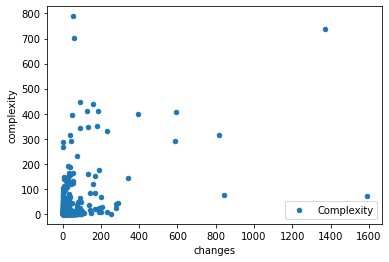

In [8]:
class_hotspots.plot.scatter(x='changes', y='complexity', label='Complexity');

This data is mostly useless. We can't see which classes are part of the hotspots. It's even unclear which points are the hotpoints.

To fix this we will to create the graph some other way. We are going to use Matplotlib.

But first we should choose which values mark the hotspots.

In [15]:
# Values to highlight. Selected with a query
highlight = class_hotspots.query("changes > 500 & complexity > 500")

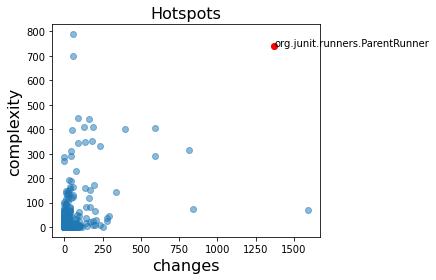

In [16]:
# Scatter plot
plt.scatter(class_hotspots["changes"], class_hotspots["complexity"], alpha=0.5)
plt.xlabel('changes',size=16)
plt.ylabel('complexity',size=16)
plt.title('Hotspots',size=16)

# Hotspots are marked
plt.scatter(highlight.changes, highlight.complexity, color="red")

# Hotspots are labeled
for i in range(highlight.shape[0]):
    plt.annotate(highlight.index.tolist()[i], (highlight.changes.tolist()[i], highlight.complexity.tolist()[i]))

plt.tight_layout()

This is better. Now we can see at a glance which classes may need a refactor.